# Return Prediction with High-Dimensional Data (II)

#### Equity premium prediction with the Goyal & Welch dataset

The PredictorData.xls file can be downloaded from Amit Goyal's website:
https://docs.google.com/spreadsheets/d/1bM7vCWd3WOt95Sf9qjLPZjoiafgF_8EG/edit?gid=407859737#gid=407859737

In [26]:
# Import necessary libraries
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import PredefinedSplit

from sklearn.metrics import mean_squared_error, mean_absolute_error

import statsmodels.api as sm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.regularizers import l1
from tensorflow.keras.utils import plot_model

import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

validation_size = 144


In [27]:
# Setting a seed for reproducibility
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)

## Preprocessing

#### Step 1: Download the Data

In [28]:
# Retrieve the data
def load_data():
    xls_path = 'PredictorData2023.xlsx'

    goyal = pd.ExcelFile(xls_path)
    df = {sheet_name: goyal.parse(sheet_name) for sheet_name in goyal.sheet_names}

    df['Monthly']['yyyymm'] = pd.to_datetime(df['Monthly']['yyyymm'].astype(str), format='%Y%m')
    df['Monthly'].set_index('yyyymm', inplace=True)
    df['Monthly'].index = df['Monthly'].index.to_period('M').to_timestamp('M')


    # create date index for annual data
    df['Annual']['yyyy'] = pd.to_datetime(df['Annual']['yyyy'].astype(str), format='%Y')
    df['Annual'].set_index('yyyy', inplace=True)
    df['Annual'].index = df['Annual'].index.to_period('Y').to_timestamp('Y')

    df = df['Monthly']

    return df

#### Step 2: Transform the Data

In [29]:
def transxf(df):

    # Dividend Price Ratio (d/p) is the difference between the log of dividends and the log of prices.
    df['d/p'] = np.log(df['D12']) - np.log(df['Index'])

    # Dividend Yield (d/y) is the difference between the log of dividends and the log of lagged prices.
    df['d/y'] = np.log(df['D12'])- np.log(df['Index'].shift(1))

    # Earnings Price Ratio (e/p) is the difference between the log of earnings and the log of prices.
    df['e/p'] = np.log(df['E12']) - np.log(df['Index'])

    # Dividend Payout Ratio (d/e) is the difference between the log of dividends and the log of earnings.
    df['d/e'] = np.log(df['D12']) - np.log(df['E12'])

    # Term Spread (tms) is the difference between the long term yield on government bonds and the T-bill.
    df['tms'] = df['lty'] - df['tbl']

    # Default Yield Spread (dfy): is the difference between BAA- and AAA- rated corporate bond yields.
    df['dfy'] = df['BAA'] - df['AAA']

    # Default Return Spread (dfr): is the difference between the return on long-term corporate bonds and returns on the long-term government bonds.
    df['dfr'] = df['corpr'] - df['ltr']

    # Calculate Index Price plus Dividends
    df['IndexDiv'] = df['Index'] + df['D12']

    # Calculate logretdiv (log return with dividends)
    df['logretdiv'] = np.log(df['IndexDiv'] / df['Index'].shift(1))

    # Calculate logRfree
    df['logRfree'] = np.log(df['Rfree'] + 1)

    # equity premium, i.e., the total rate of return on the stock market minus the prevailing short-term interest rate.
    df['premium'] = df['logretdiv'] - df['logRfree']

    df = df.drop(columns=['Index', 'csp', 'D12', 'E12', 'AAA', 'BAA', 'CRSP_SPvwx', 'corpr','Rfree', 'CRSP_SPvw'])

    return df

#### Step 3: Define the Target Variable 

In [30]:
# Define the target variable (S&P 500 Returns)
def preprocess_data(df):
    """
    Preprocess the data by creating the target variable (S&P 500 log returns) and removing NaNs.

    Args:
    df (DataFrame): Data containing S&P 500 returns.

    Returns:
    DataFrame: Processed data with target variable.
    """
    df['Target'] = df['premium'].shift(periods=-1)
    df.drop(['premium'], axis=1, inplace=True)
    df = df.apply(lambda x: x.fillna(x.rolling(window=6, min_periods=1).mean()))
    df.dropna(inplace=True)

    return df

## Estimating the Models

In [31]:
# Estimating the Forecasting Models
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop after 5 epochs with no improvement
    restore_best_weights=True  # Restore model weights from the best epoch
)

def neural_netork(input_dim):
  model = Sequential()

  model.add(Dense(16, input_shape=(input_dim,), activation='relu', kernel_regularizer=l1(0.005)))
  model.add(Dense(8, activation='relu', kernel_regularizer=l1(0.005)))
  model.add(Dense(4, activation='relu', kernel_regularizer=l1(0.005)))

  # A single Dense layer (perceptron) with 1 unit and a linear activation function
  model.add(Dense(1, activation='linear'))

  # Compile the model
  # The optimizer is set to 'adam', and the loss function to 'mean_squared_error'
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='mean_squared_error'
                )

  return model

In [32]:
def train_models(train_data_scaled, train_pca, alpha, input_dim):
    """
    Train multiple forecasting models (OLS, PCA-OLS, LASSO).

    Args:
    train_data_scaled (DataFrame): Scaled training data.
    train_pca (DataFrame): Training data after applying PCA.
    input_dim (int): Input dimension for the neural network model.

    Returns:
    Dict: Trained models.
    """
    models = {
        'ols': LinearRegression(fit_intercept=True).fit(train_data_scaled.drop("Target", axis=1),
                                                        train_data_scaled["Target"]),
        'ols_pca': LinearRegression(fit_intercept=True).fit(train_pca, train_data_scaled["Target"]),
        'lasso': Lasso(alpha=alpha, fit_intercept=True).fit(train_data_scaled.drop("Target", axis=1),
                                                            train_data_scaled['Target'])
    }

    # Neural Network training
    ann_model = neural_netork(input_dim)

    # Train the neural network model
    history = ann_model.fit(
        train_data_scaled[:-validation_size].drop("Target", axis=1),
        train_data_scaled["Target"][:-validation_size],
        epochs=500,
        batch_size=1000,
        validation_data=[train_data_scaled[-validation_size:].drop("Target", axis=1),
                         train_data_scaled["Target"][-validation_size:]],
        verbose=0,
        shuffle=False,
        callbacks=[early_stopping]
    )

    # Add the trained ANN model to the models dictionary
    models['ann'] = ann_model

    return models, history

## Generating the Forecasts

In [33]:
# Forecasts from the trained models
def generate_forecasts(models, test_data_scaled, test_pca):
    """
    Generate forecasts from the trained models.

    Args:
    models (Dict): Dictionary of trained models.
    test_data_scaled (DataFrame): Scaled test data.
    test_pca (DataFrame): Test data after applying PCA.

    Returns:
    Dict: Forecasts from each model.
    """

    forecasts = {
        'ols': models['ols'].predict(test_data_scaled.drop("Target", axis=1)),
        'ols_pca': models['ols_pca'].predict(test_pca),
        'lasso': models['lasso'].predict(test_data_scaled.drop("Target", axis=1)),
        'ann': models['ann'].predict(test_data_scaled.drop("Target", axis=1))
    }

    return forecasts

## Evaluating the Forecasts

In [34]:
# Evaluation of the models
def evaluate_models(forecast_results, actual_values):
    """
    Evaluate the models' performance using Mean Squared Error and Mean Absolute Error.

    Args:
    forecast_results (Dict): Forecasts generated by each model.
    actual_values (List): Actual target values.

    Returns:
    None
    """

    target = np.array(actual_values)
    # Iterate through all models
    for model_name, forecast_list in list(forecast_results.items()):
        forecast = np.array(forecast_list)
        mse = mean_squared_error(target, forecast)
        mae = mean_absolute_error(target, forecast)
        print(f"{model_name}: MSE = {mse}, MAE = {mae}", len(forecast_list))

In [35]:
# Visualize the forecasts
def plot_forecasts(forecast_results, actual_values, test_indices):
    """
    Plot the forecasts alongside the observed values.

    Args:
    forecast_results (Dict): Forecasts generated by each model.
    actual_values (List): Actual target values.
    test_indices (List): Indices (dates) corresponding to the test data.

    Returns:
    None
    """

    plt.figure(figsize=(12,6))
    plt.plot(test_indices, actual_values, linewidth=1, color='black', label='Observed')
    for model_name, forecast_list in list(forecast_results.items()):
            plt.plot(test_indices, forecast_list, '--', linewidth=1, label=model_name)
    plt.title('Return Forecasts')
    plt.xlabel('Date')
    plt.ylabel('Estimated Returns')
    plt.legend()
    plt.show()

## Execute the Code

In [36]:
# Load the data
df = load_data()

df = transxf(df)

# Preprocess the data
df = preprocess_data(df)

# Define initial training window size
initial_window_size = 360

# Initialize lists to store forecasts and actual values
forecast_results = {
    'ols': [],
    'ols_pca': [],
    'lasso': [],
    'ann': []
}

find_alpha = True

actual_values = []
test_indices = []


# Loop over the time steps
for t in range(initial_window_size, len(df)-1):

    # Get training data up to time t
    train_data = df.iloc[:t].copy()

    # Get test data at time t+1
    test_data = df.iloc[t:t+1].copy()

    # Check for NaN in train_data or test_data, skip if necessary
    if train_data.isnull().values.any() or test_data.isnull().values.any():
        continue  # Skip this iteration if there are NaN values

    # Scaling
    scaler = StandardScaler()
    train_data_scaled = pd.DataFrame(scaler.fit_transform(train_data), index=train_data.index, columns=train_data.columns)
    test_data_scaled = pd.DataFrame(scaler.transform(test_data), index=test_data.index, columns=test_data.columns)

    # Apply PCA
    pca = PCA(n_components=3, whiten=True, svd_solver='full')
    pca.fit(train_data_scaled.drop("Target", axis=1))

    train_pca = pd.DataFrame(pca.transform(train_data_scaled.drop("Target", axis=1)), index=train_data_scaled.index)
    test_pca = pd.DataFrame(pca.transform(test_data_scaled.drop("Target", axis=1)), index=test_data_scaled.index)

    # Get input dimension for neural network
    input_dim = len(train_data_scaled.columns) - 1  # Exclude the target column

    # Find lasso alpha via train/test split
    train_size = len(train_data_scaled) - validation_size
    test_fold = [-1] * train_size + [0] * validation_size

    # Initialize PredefinedSplit
    ps = PredefinedSplit(test_fold)

    if find_alpha:
        alpha = float(LassoCV(cv=ps).fit(train_data_scaled.drop("Target", axis=1), train_data_scaled['Target']).alpha_)
    else:
        alpha = 0.005

    # Train models
    models, history = train_models(train_data_scaled, train_pca, alpha, input_dim)

    # Generate forecasts
    test_forecasts = generate_forecasts(models, test_data_scaled, test_pca)

    # Store forecasts
    for model_name in forecast_results.keys():
        forecast_results[model_name].append(test_forecasts[model_name][0])

    # Store actual value
    actual_values.append(test_data_scaled["Target"].values[0])

    # Store test index
    test_indices.append(test_data.index[0])

/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.59388849532481

1/1 [==============================] - 0s 61ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5148398632215958, tolerance: 0.031399364051318344
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.119944658287835, tolerance: 0.031399364051318344
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.467124132262569, tolerance: 0.031399364051318344
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5906488586850571, tolerance: 0.03149229535072951
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.258457250600543, tolerance: 0.03149229535072951
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.652530159832793, tolerance: 0.03149229535072951
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 67ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.35973459041363753, tolerance: 0.03163738889182946
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8333189127817207, tolerance: 0.03163738889182946
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.1007455604739675, tolerance: 0.03163738889182946
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 55ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3465276504645374, tolerance: 0.031830480976503796
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8148129132738688, tolerance: 0.031830480976503796
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.088319638361668, tolerance: 0.031830480976503796
  model = cd_fast.enet_coordi

1/1 [==============================] - 0s 57ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.39864090460807233, tolerance: 0.03191426730825465
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9194922667709307, tolerance: 0.03191426730825465
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.229771590237618, tolerance: 0.03191426730825465
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 64ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3434841691131112, tolerance: 0.03199641492682708
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8120956496606766, tolerance: 0.03199641492682708
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.090115878507532, tolerance: 0.03199641492682708
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 55ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.28700934038292303, tolerance: 0.03209983242853691
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6963749250187163, tolerance: 0.03209983242853691
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9377530030454864, tolerance: 0.03209983242853691
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 63ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.30118585504320095, tolerance: 0.032121630563555784
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.726750716462334, tolerance: 0.032121630563555784
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9791569090392613, tolerance: 0.032121630563555784
  model = cd_fast.enet_coord

1/1 [==============================] - 0s 57ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.39971768082318704, tolerance: 0.032109432716275546
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9252547563608005, tolerance: 0.032109432716275546
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.243012414280457, tolerance: 0.032109432716275546
  model = cd_fast.enet_coord

1/1 [==============================] - 0s 55ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5533376765405364, tolerance: 0.032160719479286615
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2129617831738244, tolerance: 0.032160719479286615
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.623148182076051, tolerance: 0.032160719479286615
  model = cd_fast.enet_coordi

1/1 [==============================] - 0s 58ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9427120735911956, tolerance: 0.032252911978642544
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8610736444158533, tolerance: 0.032252911978642544
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.449301860498906, tolerance: 0.032252911978642544
  model = cd_fast.enet_coordi

1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1474890480392048, tolerance: 0.032286353187870785
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.174550525332819, tolerance: 0.032286353187870785
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.837009093626193, tolerance: 0.032286353187870785
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 62ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7711445317038113, tolerance: 0.032409550859281246
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.605280939777572, tolerance: 0.032409550859281246
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.151553572828448, tolerance: 0.032409550859281246
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6830958725981588, tolerance: 0.03263254720813321
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4665049824099867, tolerance: 0.03263254720813321
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.985001980612594, tolerance: 0.03263254720813321
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 136ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1185957652485854, tolerance: 0.032731902257295546
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3164646410206728, tolerance: 0.032731902257295546
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4547916954039124, tolerance: 0.032731902257295546
  model = cd_fast.enet_coord

1/1 [==============================] - 0s 145ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4542694696106082, tolerance: 0.032822072460074105
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0734428323551697, tolerance: 0.032822072460074105
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.495275072609729, tolerance: 0.032822072460074105
  model = cd_fast.enet_coordi

1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6049991592727224, tolerance: 0.032909530712837524
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.350220718776285, tolerance: 0.032909530712837524
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.858409965582723, tolerance: 0.032909530712837524
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 57ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.26619062567215224, tolerance: 0.03306319017533973
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6980443513208172, tolerance: 0.03306319017533973
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.003406475283612, tolerance: 0.03306319017533973
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 60ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.26618443942345493, tolerance: 0.03317728794577729
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7037053564879159, tolerance: 0.03317728794577729
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.01934484629237, tolerance: 0.03317728794577729
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15016124422857047, tolerance: 0.033426219476869475
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4268857820370613, tolerance: 0.033426219476869475
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.643839808150119, tolerance: 0.033426219476869475
  model = cd_fast.enet_coord

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7992940396803192, tolerance: 0.033776427839341705
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.710967959755692, tolerance: 0.033776427839341705
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.361363793540818, tolerance: 0.033776427839341705
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7408433664792256, tolerance: 0.033869414942504575
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.620907616519389, tolerance: 0.033869414942504575
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.256349765458111, tolerance: 0.033869414942504575
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 59ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6596910578089705, tolerance: 0.03396410343530484
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4884525830473194, tolerance: 0.03396410343530484
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.094876369971075, tolerance: 0.03396410343530484
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 56ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6470315356582432, tolerance: 0.03406685133919543
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.472989005939013, tolerance: 0.03406685133919543
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.083974580117996, tolerance: 0.03406685133919543
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5147327977187501, tolerance: 0.03415178124126249
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.242294616012259, tolerance: 0.03415178124126249
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.793999355155677, tolerance: 0.03415178124126249
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4082593390527336, tolerance: 0.03423858343813443
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0433615311001745, tolerance: 0.03423858343813443
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.53870370596789, tolerance: 0.03423858343813443
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.39224960592446223, tolerance: 0.03432700076862741
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0140044456743738, tolerance: 0.03432700076862741
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.503634381714903, tolerance: 0.03432700076862741
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7643874577993302, tolerance: 0.034451782755115276
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6857384002274216, tolerance: 0.034451782755115276
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.374145728286152, tolerance: 0.034451782755115276
  model = cd_fast.enet_coordi

1/1 [==============================] - 0s 62ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0961472990196057, tolerance: 0.03454179688638462
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.208907971236414, tolerance: 0.03454179688638462
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.021812204099774, tolerance: 0.03454179688638462
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6118783937997705, tolerance: 0.03466201688381684
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4168600914005367, tolerance: 0.03466201688381684
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.021984560113253, tolerance: 0.03466201688381684
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.48337204632633757, tolerance: 0.03477044158946101
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1763716901079704, tolerance: 0.03477044158946101
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.701252566192835, tolerance: 0.03477044158946101
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8626375216070983, tolerance: 0.03484704840672124
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8233203218767073, tolerance: 0.03484704840672124
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.5200587602533915, tolerance: 0.03484704840672124
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9387984890620373, tolerance: 0.034840713795592254
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.930781357550302, tolerance: 0.034840713795592254
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.636575867836683, tolerance: 0.034840713795592254
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 55ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7329216258040105, tolerance: 0.03493328497693195
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5868067472370058, tolerance: 0.03493328497693195
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.191711444563026, tolerance: 0.03493328497693195
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15524066237003353, tolerance: 0.03503569005011297
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4331503842789175, tolerance: 0.03503569005011297
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6488637285376626, tolerance: 0.03503569005011297
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19575133614330298, tolerance: 0.03513408770931749
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5296100995257689, tolerance: 0.03513408770931749
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7743716771447, tolerance: 0.03513408770931749
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.47456860825724334, tolerance: 0.03506877787447778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1062281051051457, tolerance: 0.03506877787447778
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.539861545196004, tolerance: 0.03506877787447778
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9304557929690418, tolerance: 0.03519091825229113
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8674000227474608, tolerance: 0.03519091825229113
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.497222835819912, tolerance: 0.03519091825229113
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 58ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3455254133089056, tolerance: 0.035379776124120244
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8347841565905583, tolerance: 0.035379776124120244
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.154727347404588, tolerance: 0.035379776124120244
  model = cd_fast.enet_coordi

1/1 [==============================] - 0s 63ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.44371633780770026, tolerance: 0.03545631559268167
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0177717063011187, tolerance: 0.03545631559268167
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.385040438740617, tolerance: 0.03545631559268167
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7753542588859546, tolerance: 0.03565672698474728
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5851117027444843, tolerance: 0.03565672698474728
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.101785773699788, tolerance: 0.03565672698474728
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06144201253744086, tolerance: 0.03574549316795366
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0844751646603754, tolerance: 0.03574549316795366
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0550392003593174, tolerance: 0.03574549316795366
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8935251698483739, tolerance: 0.03586043931334822
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7529476679736717, tolerance: 0.03586043931334822
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.285960122830659, tolerance: 0.03586043931334822
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.973443360834267, tolerance: 0.035950184812786834
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.857711486949256, tolerance: 0.035950184812786834
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.3920755147303225, tolerance: 0.035950184812786834
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.34860518027124954, tolerance: 0.03592818342559129
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7689176155890323, tolerance: 0.03592818342559129
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.968852473200627, tolerance: 0.03592818342559129
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08054096161407642, tolerance: 0.03610105851054009
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.102796046376966, tolerance: 0.03610105851054009
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0105581937446573, tolerance: 0.03610105851054009
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2301768762804386, tolerance: 0.03643358092857567
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4997360161674465, tolerance: 0.03643358092857567
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5815279601031307, tolerance: 0.03643358092857567
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1688234056557576, tolerance: 0.03654254783193423
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3333790403105468, tolerance: 0.03654254783193423
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.320963416294205, tolerance: 0.03654254783193423
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.324990641702982, tolerance: 0.03660677172374962
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6651879142810913, tolerance: 0.03660677172374962
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0253619671555612, tolerance: 0.03660677172374962
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7515494815905299, tolerance: 0.036715072173413285
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4078616435780873, tolerance: 0.036715072173413285
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5096791965767125, tolerance: 0.036715072173413285
  model = cd_fast.enet_coord

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6105353889067828, tolerance: 0.03683938320218871
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.155954089642705, tolerance: 0.03683938320218871
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.107358518416163, tolerance: 0.03683938320218871
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8863936032386164, tolerance: 0.03692135611488772
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5860959433014727, tolerance: 0.03692135611488772
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08653129135643667, tolerance: 0.03692135611488772
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1686768763858595, tolerance: 0.037021076866555085
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2634280858822535, tolerance: 0.037021076866555085
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6568179313342739, tolerance: 0.037021076866555085
  model = cd_fast.enet_coord

1/1 [==============================] - 0s 56ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14127980244535365, tolerance: 0.03705536425071231
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.181045079260059, tolerance: 0.03705536425071231
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6130662337641866, tolerance: 0.03705536425071231
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7757643424132539, tolerance: 0.037263556975215356
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.37171994329816, tolerance: 0.037263556975215356
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09707968386339871, tolerance: 0.037263556975215356
  model = cd_fast.enet_coordi

1/1 [==============================] - 0s 59ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7590937453404649, tolerance: 0.03736564083156754
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.337513449550954, tolerance: 0.03736564083156754
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11390195086147514, tolerance: 0.03736564083156754
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 55ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5034909639567218, tolerance: 0.03744034529690318
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.899395543243088, tolerance: 0.03744034529690318
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4658748090398035, tolerance: 0.03744034529690318
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3751355895198003, tolerance: 0.037566606480301315
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6559812819835429, tolerance: 0.037566606480301315
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9936081432390438, tolerance: 0.037566606480301315
  model = cd_fast.enet_coord

1/1 [==============================] - 0s 56ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3670135742473235, tolerance: 0.037658392651937975
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6352843638925947, tolerance: 0.037658392651937975
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.055355132951604, tolerance: 0.037658392651937975
  model = cd_fast.enet_coordi

1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14266074924012173, tolerance: 0.037804153035616204
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1453562743203065, tolerance: 0.037804153035616204
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.893977726113235, tolerance: 0.037804153035616204
  model = cd_fast.enet_coord

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8674123999571179, tolerance: 0.03782721445674774
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.475300835368216, tolerance: 0.03782721445674774
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.45405778791803186, tolerance: 0.03782721445674774
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7117151059059665, tolerance: 0.037925116104548476
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2269591813267766, tolerance: 0.037925116104548476
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2510065250763205, tolerance: 0.037925116104548476
  model = cd_fast.enet_coord

1/1 [==============================] - 0s 58ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5177907277339955, tolerance: 0.037999883096734896
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8982507308062395, tolerance: 0.037999883096734896
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05142935792719072, tolerance: 0.037999883096734896
  model = cd_fast.enet_coor

1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16682628937570598, tolerance: 0.037997088182510526
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.191890355798762, tolerance: 0.037997088182510526
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.944371656308874, tolerance: 0.037997088182510526
  model = cd_fast.enet_coordi

1/1 [==============================] - 0s 55ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7048397679770346, tolerance: 0.03788611767233976
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.196159914067721, tolerance: 0.03788611767233976
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.30165564641498577, tolerance: 0.03788611767233976
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07853529085116406, tolerance: 0.03781802894947914
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9375130270300929, tolerance: 0.03781802894947914
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.548720196336319, tolerance: 0.03781802894947914
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7607092887313911, tolerance: 0.03788258383703333
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.267092368606825, tolerance: 0.03788258383703333
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4356864101590645, tolerance: 0.03788258383703333
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 56ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4612031078717109, tolerance: 0.03801639192320117
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.763361803024452, tolerance: 0.03801639192320117
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9993816783647844, tolerance: 0.03801639192320117
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19212761174793513, tolerance: 0.0381124307819053
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2248110025994379, tolerance: 0.0381124307819053
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9564710891631876, tolerance: 0.0381124307819053
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12601129691563528, tolerance: 0.03820423316852708
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0600440615979778, tolerance: 0.03820423316852708
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7156468131250904, tolerance: 0.03820423316852708
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8828401938861248, tolerance: 0.03818225689613919
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4440532509374293, tolerance: 0.03818225689613919
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6489475718253743, tolerance: 0.03818225689613919
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5932980264489061, tolerance: 0.0383495350193733
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9856763122134566, tolerance: 0.0383495350193733
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2488158803519127, tolerance: 0.0383495350193733
  model = cd_fast.enet_coordinate_

1/1 [==============================] - 0s 60ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3271380831520787, tolerance: 0.03853730470486782
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5109687803845304, tolerance: 0.03853730470486782
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3619428076137865, tolerance: 0.03853730470486782
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10441603041095959, tolerance: 0.038581335962166174
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.002052814933279, tolerance: 0.038581335962166174
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6359554439368935, tolerance: 0.038581335962166174
  model = cd_fast.enet_coord

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8354078515595234, tolerance: 0.0386678636432476
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.380896723743433, tolerance: 0.0386678636432476
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5229915865731414, tolerance: 0.0386678636432476
  model = cd_fast.enet_coordinate_d

1/1 [==============================] - 0s 60ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.43254712981308785, tolerance: 0.03882042420656183
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7103822674629328, tolerance: 0.03882042420656183
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6347618791455147, tolerance: 0.03882042420656183
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4464899367681596, tolerance: 0.038924957943427985
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7364547334453846, tolerance: 0.038924957943427985
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6711035148881592, tolerance: 0.038924957943427985
  model = cd_fast.enet_coord

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.31543919156769107, tolerance: 0.038977946292738354
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4863550032718535, tolerance: 0.038977946292738354
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.329222362087762, tolerance: 0.038977946292738354
  model = cd_fast.enet_coord

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12575388554466826, tolerance: 0.03918883107663935
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.064125122975895, tolerance: 0.03918883107663935
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.736893057310681, tolerance: 0.03918883107663935
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 56ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6158981870854632, tolerance: 0.03931608206986464
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0424522104532343, tolerance: 0.03931608206986464
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.093728838754998, tolerance: 0.03931608206986464
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 58ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.31232052328573445, tolerance: 0.03938071434260928
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4919573538763302, tolerance: 0.03938071434260928
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.355487355353432, tolerance: 0.03938071434260928
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.19616634178805725, tolerance: 0.039470468762202886
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.242270478327839, tolerance: 0.039470468762202886
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.002951330231042, tolerance: 0.039470468762202886
  model = cd_fast.enet_coordi

1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8020458845202825, tolerance: 0.03953501067312057
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.342444713536679, tolerance: 0.03953501067312057
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.4786562862535675, tolerance: 0.03953501067312057
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.30500374598955204, tolerance: 0.03966046777151718
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4757524161226456, tolerance: 0.03966046777151718
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.331135805613485, tolerance: 0.03966046777151718
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 55ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12120787256503718, tolerance: 0.039755545873810506
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0549033691761451, tolerance: 0.039755545873810506
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7287053583745546, tolerance: 0.039755545873810506
  model = cd_fast.enet_coor

1/1 [==============================] - 0s 55ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14360732616489713, tolerance: 0.03986709906773251
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1125831624828493, tolerance: 0.03986709906773251
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8117540873175813, tolerance: 0.03986709906773251
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.39319567554468904, tolerance: 0.04000558972186857
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.647007496403944, tolerance: 0.04000558972186857
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.565372303131369, tolerance: 0.04000558972186857
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.49455566558890496, tolerance: 0.04012575525554245
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.831385457819863, tolerance: 0.04012575525554245
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8125046565256184, tolerance: 0.04012575525554245
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8814672664570367, tolerance: 0.040226021670676904
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.465688719632908, tolerance: 0.040226021670676904
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.635170790367283, tolerance: 0.040226021670676904
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3240519451380237, tolerance: 0.04036073244374004
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5141994033184574, tolerance: 0.04036073244374004
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3848045188967717, tolerance: 0.04036073244374004
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09234804324819379, tolerance: 0.0404552130358883
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9736124014238499, tolerance: 0.0404552130358883
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6081490376226384, tolerance: 0.0404552130358883
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8333133469880067, tolerance: 0.04051377008769872
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3906589927736945, tolerance: 0.04051377008769872
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.539012206384825, tolerance: 0.04051377008769872
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8812994981295219, tolerance: 0.040611857803820026
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.463687097341051, tolerance: 0.040611857803820026
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.629762295302612, tolerance: 0.040611857803820026
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.691495402334624, tolerance: 0.04069478352869631
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.16265738401637, tolerance: 0.04069478352869631
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.24343483418636, tolerance: 0.04069478352869631
  model = cd_fast.enet_coordinate_de

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13254901733887436, tolerance: 0.040808567454954085
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0842536722841487, tolerance: 0.040808567454954085
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7707916289021455, tolerance: 0.040808567454954085
  model = cd_fast.enet_coor

1/1 [==============================] - 0s 58ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6266196338108898, tolerance: 0.04090911277547949
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.058705595901529, tolerance: 0.04090911277547949
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.112730214021383, tolerance: 0.04090911277547949
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 58ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.665955687965436, tolerance: 0.041001310375383127
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.123055743724592, tolerance: 0.041001310375383127
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.195309171406109, tolerance: 0.041001310375383127
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6225283263340771, tolerance: 0.041086630289249776
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.050064951558795, tolerance: 0.041086630289249776
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.098851743351361, tolerance: 0.041086630289249776
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6469064132668336, tolerance: 0.04115832906130771
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.089406403361693, tolerance: 0.04115832906130771
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.148571790444464, tolerance: 0.04115832906130771
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7694767916657952, tolerance: 0.04126506745750542
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2867734953799186, tolerance: 0.04126506745750542
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.401929252746413, tolerance: 0.04126506745750542
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6553365729386087, tolerance: 0.041331442654006706
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.100864877227366, tolerance: 0.041331442654006706
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.160368430397909, tolerance: 0.041331442654006706
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 57ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5665778224541214, tolerance: 0.041310488181337125
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9485456276004811, tolerance: 0.041310488181337125
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.956600909511849, tolerance: 0.041310488181337125
  model = cd_fast.enet_coordi

1/1 [==============================] - 0s 57ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23385758492844388, tolerance: 0.04141150455266693
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3186569219698185, tolerance: 0.04141150455266693
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.100334998402559, tolerance: 0.04141150455266693
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.45138190187554983, tolerance: 0.04157880581343125
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7472866282163295, tolerance: 0.04157880581343125
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.691408314245905, tolerance: 0.04157880581343125
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.33908300313487416, tolerance: 0.041667864448503206
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5344783016474821, tolerance: 0.041667864448503206
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4003059377191676, tolerance: 0.041667864448503206
  model = cd_fast.enet_coor

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0968784241330809, tolerance: 0.04181753850362193
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9806949467445634, tolerance: 0.04181753850362193
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.610598545577716, tolerance: 0.04181753850362193
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.778630601476948, tolerance: 0.04188407135523554
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2988418456772024, tolerance: 0.04188407135523554
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.416575315511125, tolerance: 0.04188407135523554
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 65ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.66791516608248, tolerance: 0.04196809568237092
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1200169079222633, tolerance: 0.04196809568237092
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.185779408572557, tolerance: 0.04196809568237092
  model = cd_fast.enet_coordinate_

1/1 [==============================] - 0s 58ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2628024482964406, tolerance: 0.04210393635287503
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3833675003620556, tolerance: 0.04210393635287503
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1976241160727454, tolerance: 0.04210393635287503
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.17915729751314302, tolerance: 0.04215433607884409
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1963569148132933, tolerance: 0.04215433607884409
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9312433823166657, tolerance: 0.04215433607884409
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 56ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07930301875740042, tolerance: 0.04221551114383397
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9290090060098919, tolerance: 0.04221551114383397
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.536570957083484, tolerance: 0.04221551114383397
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5701675255327814, tolerance: 0.04234762381870543
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9616603382393123, tolerance: 0.04234762381870543
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.987532741134544, tolerance: 0.04234762381870543
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.30627732722086876, tolerance: 0.04231941301636112
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4734316114382295, tolerance: 0.04231941301636112
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.325083006858506, tolerance: 0.04231941301636112
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24014875402582447, tolerance: 0.042379149381854636
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3345587955918745, tolerance: 0.042379149381854636
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.12991960940667, tolerance: 0.042379149381854636
  model = cd_fast.enet_coordi

1/1 [==============================] - 0s 55ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12291465266866908, tolerance: 0.04249394455184468
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0565976169881424, tolerance: 0.04249394455184468
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7315481247082403, tolerance: 0.04249394455184468
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08736991781341885, tolerance: 0.04241626679757795
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9520607564232932, tolerance: 0.04241626679757795
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.569902844696969, tolerance: 0.04241626679757795
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3992258565864404, tolerance: 0.04260429470164959
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6576774347351488, tolerance: 0.04260429470164959
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5842021617009436, tolerance: 0.04260429470164959
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.42093248629606705, tolerance: 0.04269962330378906
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.698910496261135, tolerance: 0.04269962330378906
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6414183923122323, tolerance: 0.04269962330378906
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12744221381973375, tolerance: 0.04288532664317607
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0742687048988273, tolerance: 0.04288532664317607
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.767232914746785, tolerance: 0.04288532664317607
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15113552569198418, tolerance: 0.042995127800767204
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1377502586352648, tolerance: 0.042995127800767204
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8640512095531676, tolerance: 0.042995127800767204
  model = cd_fast.enet_coor

1/1 [==============================] - 0s 57ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15935819355314607, tolerance: 0.043022300352796077
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1591339398362948, tolerance: 0.043022300352796077
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8966365845562905, tolerance: 0.043022300352796077
  model = cd_fast.enet_coor

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14269892722609256, tolerance: 0.04310722324315441
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1196385422264257, tolerance: 0.04310722324315441
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8428647168400403, tolerance: 0.04310722324315441
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1403325353155651, tolerance: 0.043200780497290106
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1161060493353716, tolerance: 0.043200780497290106
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8417316667392925, tolerance: 0.043200780497290106
  model = cd_fast.enet_coord

1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14126629570569094, tolerance: 0.04329318920855867
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1220381611146308, tolerance: 0.04329318920855867
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8560103523296902, tolerance: 0.04329318920855867
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 59ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0969840896026426, tolerance: 0.04326613235466599
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0001559965867273, tolerance: 0.04326613235466599
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.674693701852277, tolerance: 0.04326613235466599
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8619763155498958, tolerance: 0.0434425318961863
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.471172306290555, tolerance: 0.0434425318961863
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 55ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12137398602931171, tolerance: 0.043556771429079266
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.07840346132798, tolerance: 0.043556771429079266
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.806340547918012, tolerance: 0.043556771429079266
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8599842711019505, tolerance: 0.043641026354360866
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4794745423977815, tolerance: 0.043641026354360866
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8375600479378136, tolerance: 0.04373123224749622
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.452511256642026, tolerance: 0.04373123224749622
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7564697465634822, tolerance: 0.043823282244739505
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3299499104256256, tolerance: 0.043823282244739505
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3543396904848919, tolerance: 0.0439634692384489
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6288209767331523, tolerance: 0.0439634692384489
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 55ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3334702126459206, tolerance: 0.044066055049590554
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5923158503973696, tolerance: 0.044066055049590554
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.437793809501386, tolerance: 0.04413757134180784
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8013490234317828, tolerance: 0.04413757134180784
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23637783069995066, tolerance: 0.04416889668235033
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3979473584145694, tolerance: 0.04416889668235033
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10778748631264534, tolerance: 0.044304633574080314
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.079890212097041, tolerance: 0.044304633574080314
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1322773797010086, tolerance: 0.04434240806615429
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1521307329727506, tolerance: 0.04434240806615429
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.38774148896834504, tolerance: 0.04461880879877774
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7325908829775472, tolerance: 0.04461880879877774
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07306229154028188, tolerance: 0.04471166167935689
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9892756884087248, tolerance: 0.04471166167935689
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5731118920864446, tolerance: 0.04478022552994226
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7184775238978887, tolerance: 0.04495225585142829
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1050974529205746, tolerance: 0.04514154451231261
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1055382116215924, tolerance: 0.04514154451231261
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9990271831958921, tolerance: 0.045229344652117316
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13515311501254246, tolerance: 0.04533200649102445
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1987133343959613, tolerance: 0.04533200649102445
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 60ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8286236432203395, tolerance: 0.04532394709040362
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11565446112672362, tolerance: 0.04548706562758128
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1521259779817115, tolerance: 0.04548706562758128
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21401427065995904, tolerance: 0.045527610596415385
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4097884759469252, tolerance: 0.045527610596415385
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13340747733360558, tolerance: 0.045615317465154646
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2090033709363297, tolerance: 0.045615317465154646
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9325477680251311, tolerance: 0.04571130661194211
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7436483169644248, tolerance: 0.04579037350891439
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 65ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7059308914012377, tolerance: 0.045747953135351835
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 61ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6417530054999929, tolerance: 0.04568512237254326
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 55ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8547239459633147, tolerance: 0.045918617265975
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 57ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23609039722185798, tolerance: 0.04612225445246573
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.493029673446756, tolerance: 0.04612225445246573
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6409832756905303, tolerance: 0.04626086067630797
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2879067586201813, tolerance: 0.04626086067630797
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 60ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5767521315915474, tolerance: 0.04627680827297322
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.175319591122957, tolerance: 0.04627680827297322
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0628149083764242, tolerance: 0.04640758053294701
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.975057035729776, tolerance: 0.04640758053294701
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46431418969848437, tolerance: 0.0462977392310078
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9673829455861096, tolerance: 0.0462977392310078
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 55ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.810814846232006, tolerance: 0.046394011791224536
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5733502850226273, tolerance: 0.046394011791224536
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 75ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5400079854948103, tolerance: 0.04648289485493475
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1129704705812173, tolerance: 0.04648289485493475
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 64ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4097597641357993, tolerance: 0.04630336137783647
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8655423714324115, tolerance: 0.04630336137783647
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 58ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.43548148144594734, tolerance: 0.046262735502758896
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9171445588458482, tolerance: 0.046262735502758896
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.521574760300723, tolerance: 0.04626553806082541
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.082618158820651, tolerance: 0.04626553806082541
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7280976696354173, tolerance: 0.04629381667882967
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4498921756478467, tolerance: 0.04629381667882967
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9441199078086129, tolerance: 0.04636577727028649
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.808688405861915, tolerance: 0.04636577727028649
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 60ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13457785621528728, tolerance: 0.04646420664971691
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2635901188614866, tolerance: 0.04646420664971691
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3073415576417915, tolerance: 0.04646420664971691
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 55ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2924143219044595, tolerance: 0.046536453196150414
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.653829309252444, tolerance: 0.046536453196150414
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.880451308821705, tolerance: 0.046536453196150414
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 60ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5585792520943755, tolerance: 0.04660593725538076
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.185936257082176, tolerance: 0.04660593725538076
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.621490859693608, tolerance: 0.04660593725538076
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0924508234635368, tolerance: 0.04668100216459896
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.096377935347391, tolerance: 0.04668100216459896
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.833695609983181, tolerance: 0.04668100216459896
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0662801935030757, tolerance: 0.046772732135180684
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0664266478443096, tolerance: 0.046772732135180684
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.81015041607975, tolerance: 0.046772732135180684
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 61ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09258624790055592, tolerance: 0.046874776388863136
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1850627194698404, tolerance: 0.046874776388863136
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2614220816594184, tolerance: 0.046874776388863136
  model = cd_fast.enet_coor

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16509415304324193, tolerance: 0.04697356308263192
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4061118874488443, tolerance: 0.04697356308263192
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6047903659926988, tolerance: 0.04697356308263192
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5113831722280793, tolerance: 0.047061376732621056
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1683709227503414, tolerance: 0.047061376732621056
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.6908799852023435, tolerance: 0.047061376732621056
  model = cd_fast.enet_coord

1/1 [==============================] - 0s 56ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6796283624911439, tolerance: 0.04706096625038489
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.481831499990335, tolerance: 0.04706096625038489
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.120271012403521, tolerance: 0.04706096625038489
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.674891757846467, tolerance: 0.04716316991029368
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.486289780282334, tolerance: 0.04716316991029368
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.142486035073034, tolerance: 0.04716316991029368
  model = cd_fast.enet_coordinate_

1/1 [==============================] - 0s 55ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0850461811145351, tolerance: 0.04716362815611068
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2056943823611164, tolerance: 0.04716362815611068
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3614143573672663, tolerance: 0.04716362815611068
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 57ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9592301150987623, tolerance: 0.047292281128659866
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9895991686266825, tolerance: 0.047292281128659866
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.8297000200519165, tolerance: 0.047292281128659866
  model = cd_fast.enet_coord

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.40466896941455843, tolerance: 0.04749904681886119
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.019858047006153, tolerance: 0.04749904681886119
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.56904151435657, tolerance: 0.04749904681886119
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3929350827418716, tolerance: 0.04750443766444684
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0076179138692964, tolerance: 0.04750443766444684
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.568547279499057, tolerance: 0.04750443766444684
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 57ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4258579746954183, tolerance: 0.04758577057845253
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0854339341601644, tolerance: 0.04758577057845253
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.690704118331382, tolerance: 0.04758577057845253
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.44404089302247485, tolerance: 0.047590327494599634
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1304596841202397, tolerance: 0.047590327494599634
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.764203863573698, tolerance: 0.047590327494599634
  model = cd_fast.enet_coord

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1691155621950884, tolerance: 0.047928634126405294
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5214802385671646, tolerance: 0.047928634126405294
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9276816028151416, tolerance: 0.047928634126405294
  model = cd_fast.enet_coord

1/1 [==============================] - 0s 63ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.13795427338658328, tolerance: 0.048022247186108126
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4441335981657062, tolerance: 0.048022247186108126
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8297856172108595, tolerance: 0.048022247186108126
  model = cd_fast.enet_coor

1/1 [==============================] - 0s 57ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11746704139437725, tolerance: 0.04813949237080493
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3888825925536707, tolerance: 0.04813949237080493
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7577646758413152, tolerance: 0.04813949237080493
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09876530030498998, tolerance: 0.04825796580297426
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3348379095897371, tolerance: 0.04825796580297426
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.686083635431828, tolerance: 0.04825796580297426
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 59ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05551591711684978, tolerance: 0.04834630247695287
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1810336774520351, tolerance: 0.04834630247695287
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.459610461231023, tolerance: 0.04834630247695287
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 56ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0787188535589394, tolerance: 0.048388889454655776
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3051553692069433, tolerance: 0.048388889454655776
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.394773495575066, tolerance: 0.048388889454655776
  model = cd_fast.enet_coordi

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0059449750879708, tolerance: 0.048521563787777694
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.195904189602402, tolerance: 0.048521563787777694
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.265706754326857, tolerance: 0.048521563787777694
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1291988377300868, tolerance: 0.048608261599095086
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4034752235820065, tolerance: 0.048608261599095086
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.543722336497638, tolerance: 0.048608261599095086
  model = cd_fast.enet_coordi

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7803230234005696, tolerance: 0.04885191776036926
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8377376912972636, tolerance: 0.04885191776036926
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.829246675020272, tolerance: 0.04885191776036926
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6973314349402244, tolerance: 0.048948202131474515
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6997332904112454, tolerance: 0.048948202131474515
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.658846804695202, tolerance: 0.048948202131474515
  model = cd_fast.enet_coordi

1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5589684457222006, tolerance: 0.04903831112200795
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.452226520646036, tolerance: 0.04903831112200795
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.339431191561118, tolerance: 0.04903831112200795
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5735864398579906, tolerance: 0.0491374794878169
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.486312373776741, tolerance: 0.0491374794878169
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.3944612249022725, tolerance: 0.0491374794878169
  model = cd_fast.enet_coordinate_d

1/1 [==============================] - 0s 55ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9494005733691324, tolerance: 0.049219982768802344
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1564949541143505, tolerance: 0.049219982768802344
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.287610697771299, tolerance: 0.049219982768802344
  model = cd_fast.enet_coordi

1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06177936600505518, tolerance: 0.04921836830332471
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.253041204386136, tolerance: 0.04921836830332471
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6473067346939843, tolerance: 0.04921836830332471
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1919729108706747, tolerance: 0.04929175332986409
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6734850244518498, tolerance: 0.04929175332986409
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.287798737209187, tolerance: 0.04929175332986409
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21513126156179396, tolerance: 0.04929383219216996
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7390587340310049, tolerance: 0.04929383219216996
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.390090289653813, tolerance: 0.04929383219216996
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 59ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3077285026779464, tolerance: 0.04934338163470027
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9709112975703533, tolerance: 0.04934338163470027
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.732337308837145, tolerance: 0.04934338163470027
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10425884671548147, tolerance: 0.049492647655790846
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4319058259991948, tolerance: 0.049492647655790846
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.957656795312573, tolerance: 0.049492647655790846
  model = cd_fast.enet_coord

1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3434996515910598, tolerance: 0.04957835529545774
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0697713756231337, tolerance: 0.04957835529545774
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.897750415886549, tolerance: 0.04957835529545774
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5640705114134903, tolerance: 0.04958068021371063
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.527670618964521, tolerance: 0.04958068021371063
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.53314084058934, tolerance: 0.04958068021371063
  model = cd_fast.enet_coordinate_

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.39679829157989843, tolerance: 0.04971963939325277
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1971422922454735, tolerance: 0.04971963939325277
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.091428127758093, tolerance: 0.04971963939325277
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8051832059267099, tolerance: 0.049793552559324494
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9853893873233233, tolerance: 0.049793552559324494
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.165019612194158, tolerance: 0.049793552559324494
  model = cd_fast.enet_coordi

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0293982803422637, tolerance: 0.04943047140132197
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3589218346428424, tolerance: 0.04943047140132197
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.640651190669985, tolerance: 0.04943047140132197
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 56ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.031939742436009, tolerance: 0.049533201024085746
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3723524318403406, tolerance: 0.049533201024085746
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.670279369461014, tolerance: 0.049533201024085746
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6148773794529916, tolerance: 0.049713629222858956
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6546566281365926, tolerance: 0.049713629222858956
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.745688420285546, tolerance: 0.049713629222858956
  model = cd_fast.enet_coordi

1/1 [==============================] - 0s 56ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7639229693933203, tolerance: 0.049793549706635985
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9384462122367268, tolerance: 0.049793549706635985
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.138087222671345, tolerance: 0.049793549706635985
  model = cd_fast.enet_coordi

1/1 [==============================] - 0s 47ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.706642869068844, tolerance: 0.049870751954390675
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.842796663088393, tolerance: 0.049870751954390675
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.02197658664943, tolerance: 0.049870751954390675
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 56ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.36379803669797184, tolerance: 0.05008973365336435
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.173134427514128, tolerance: 0.05008973365336435
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.126894321561849, tolerance: 0.05008973365336435
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4411163239760185, tolerance: 0.050448413783833045
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.352814996149448, tolerance: 0.050448413783833045
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.395939358082842, tolerance: 0.050448413783833045
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 56ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9185124490104499, tolerance: 0.05079998884063351
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2558932673597383, tolerance: 0.05079998884063351
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.619625621858916, tolerance: 0.05079998884063351
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 56ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2588343311473409, tolerance: 0.05073909326407937
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9546505749793255, tolerance: 0.05073909326407937
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.8575794605000056, tolerance: 0.05073909326407937
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 56ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.21187636766313744, tolerance: 0.05059827490658024
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.831756953366721, tolerance: 0.05059827490658024
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.676528740053811, tolerance: 0.05059827490658024
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 55ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.416875023829391, tolerance: 0.05043339034906639
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.312456485428129, tolerance: 0.05043339034906639
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.35430302465295, tolerance: 0.05043339034906639
  model = cd_fast.enet_coordinate_d

1/1 [==============================] - 0s 55ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2758563883766101, tolerance: 0.050027117645045374
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9899668156633084, tolerance: 0.050027117645045374
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.895414220740918, tolerance: 0.050027117645045374
  model = cd_fast.enet_coordi

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9633624271982626, tolerance: 0.05019360740350446
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3383089603287317, tolerance: 0.05019360740350446
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.73124072195975, tolerance: 0.05019360740350446
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9598536634876496, tolerance: 0.05027103849812793
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3388251248858865, tolerance: 0.05027103849812793
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.740588880435723, tolerance: 0.05027103849812793
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5671822555434574, tolerance: 0.05010023160554061
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.633420346863204, tolerance: 0.05010023160554061
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.812259757363847, tolerance: 0.05010023160554061
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5534466777731382, tolerance: 0.05019540355916959
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.61365098430457, tolerance: 0.05019540355916959
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.7955158380671605, tolerance: 0.05019540355916959
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3723833899006195, tolerance: 0.050281756996434716
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2462187689678217, tolerance: 0.050281756996434716
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.304068235940292, tolerance: 0.050281756996434716
  model = cd_fast.enet_coordi

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2710207759720902, tolerance: 0.050352431230968206
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.016581621761077, tolerance: 0.050352431230968206
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.990148485639168, tolerance: 0.050352431230968206
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 57ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.26812057233922815, tolerance: 0.050418633898586473
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.015219045309607, tolerance: 0.050418633898586473
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.996950686832406, tolerance: 0.050418633898586473
  model = cd_fast.enet_coordi

1/1 [==============================] - 0s 56ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.26074119266831985, tolerance: 0.050533545331774475
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0041747099695044, tolerance: 0.050533545331774475
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.99213161947489, tolerance: 0.050533545331774475
  model = cd_fast.enet_coordi

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23940463304973036, tolerance: 0.05049153960891129
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.953829733954933, tolerance: 0.05049153960891129
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.925314527170997, tolerance: 0.05049153960891129
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1364431600962348, tolerance: 0.05057058986782766
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6712594101333025, tolerance: 0.05057058986782766
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.524555746109968, tolerance: 0.05057058986782766
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11883282829126074, tolerance: 0.05064663214198835
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.619921934946035, tolerance: 0.05064663214198835
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.456639627955269, tolerance: 0.05064663214198835
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 58ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09848836683249829, tolerance: 0.05068080090761534
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.557279231259713, tolerance: 0.05068080090761534
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.373783968498969, tolerance: 0.05068080090761534
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 61ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08848880654119284, tolerance: 0.0507951735641546
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.527674396352154, tolerance: 0.0507951735641546
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.339877333251934, tolerance: 0.0507951735641546
  model = cd_fast.enet_coordinate_d

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07472252066878582, tolerance: 0.050869765804607794
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4817347511161643, tolerance: 0.050869765804607794
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.281246010573852, tolerance: 0.050869765804607794
  model = cd_fast.enet_coord

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0836205892255748, tolerance: 0.05074452553059899
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.518315937213174, tolerance: 0.05074452553059899
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.339797039804978, tolerance: 0.05074452553059899
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08474901330481543, tolerance: 0.0508224711791931
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.529310455400605, tolerance: 0.0508224711791931
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.367271760029041, tolerance: 0.0508224711791931
  model = cd_fast.enet_coordinate_d

1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10015192121051086, tolerance: 0.050906642762485924
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5928481398122472, tolerance: 0.050906642762485924
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.474491495902612, tolerance: 0.050906642762485924
  model = cd_fast.enet_coord

1/1 [==============================] - 0s 57ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.092558773742212, tolerance: 0.05098748815135601
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5710943273160183, tolerance: 0.05098748815135601
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.450997259425435, tolerance: 0.05098748815135601
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08529124088420303, tolerance: 0.05106077537974981
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.549777585073059, tolerance: 0.05106077537974981
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.42827617118769, tolerance: 0.05106077537974981
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10398228565441059, tolerance: 0.051135476024759145
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6248752998124587, tolerance: 0.051135476024759145
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.552398554423235, tolerance: 0.051135476024759145
  model = cd_fast.enet_coord

1/1 [==============================] - 0s 47ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10590723993993834, tolerance: 0.05121086994878261
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6379322503321418, tolerance: 0.05121086994878261
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.582167810481394, tolerance: 0.05121086994878261
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.088854546485436, tolerance: 0.0513344885554861
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5819621226985419, tolerance: 0.0513344885554861
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.50754035942748, tolerance: 0.0513344885554861
  model = cd_fast.enet_coordinate_des

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.09396537590316711, tolerance: 0.051419524350648296
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6085051239480777, tolerance: 0.051419524350648296
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.55982621476096, tolerance: 0.051419524350648296
  model = cd_fast.enet_coordi

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08629297593574847, tolerance: 0.05148486632240016
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5845430781120058, tolerance: 0.05148486632240016
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.5315226440488345, tolerance: 0.05148486632240016
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.07970061351852564, tolerance: 0.05158692706839378
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5652143020815856, tolerance: 0.05158692706839378
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.512411521532954, tolerance: 0.05158692706839378
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08988939674117091, tolerance: 0.051652786568635305
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6108951892421715, tolerance: 0.051652786568635305
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.591958372246495, tolerance: 0.051652786568635305
  model = cd_fast.enet_coord

1/1 [==============================] - 0s 59ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05469217688698791, tolerance: 0.05165011091188528
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.468446319972088, tolerance: 0.05165011091188528
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.379657467418895, tolerance: 0.05165011091188528
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4502738949238392, tolerance: 0.05173385761049372
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.36078941433874, tolerance: 0.05173385761049372
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0565400052851146, tolerance: 0.05185189583182722
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4900050914764051, tolerance: 0.05185189583182722
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.434506288963689, tolerance: 0.05185189583182722
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 56ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2646066977609962, tolerance: 0.05193811501765519
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.0893665534342745, tolerance: 0.05193811501765519
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.284750289302906, tolerance: 0.05203310130226995
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.131603906228349, tolerance: 0.05203310130226995
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05975259067713523, tolerance: 0.05223542934481508
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.527638889911998, tolerance: 0.05223542934481508
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.530484239391228, tolerance: 0.05223542934481508
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 59ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.272871273546059, tolerance: 0.05231208294535144
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.136772788824089, tolerance: 0.05231208294535144
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0933386926224102, tolerance: 0.05238156673276583
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8480301372105714, tolerance: 0.05238156673276583
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8976333384493387, tolerance: 0.052467567355357306
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5185895976933352, tolerance: 0.052467567355357306
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8106159975236551, tolerance: 0.0525017235020338
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.369527045349116, tolerance: 0.0525017235020338
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8171749319431569, tolerance: 0.05260736796417325
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3928038386309254, tolerance: 0.05260736796417325
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.756693899513948, tolerance: 0.05270075125361486
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2922994054490005, tolerance: 0.05270075125361486
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 47ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7861559473551551, tolerance: 0.0527058496960579
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.355188111637119, tolerance: 0.0527058496960579
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.925622881593199, tolerance: 0.05282934885950323
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6216573141248887, tolerance: 0.05282934885950323
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.170383649067162, tolerance: 0.05295741993871247
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.057812697258839, tolerance: 0.05295741993871247
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 61ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5973571807036819, tolerance: 0.05289716450305662
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.022257348370772, tolerance: 0.05289716450305662
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 56ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5537784496546578, tolerance: 0.05314969496654568
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.701127904943689, tolerance: 0.05314969496654568
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.16080750473503258, tolerance: 0.05326603905199105
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9920875576186177, tolerance: 0.05326603905199105
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.377292732611579, tolerance: 0.05326603905199105
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.26464267887411097, tolerance: 0.053328021819036786
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2947643654193257, tolerance: 0.053328021819036786
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.825539040785372, tolerance: 0.053328021819036786
  model = cd_fast.enet_coord

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24748516436977752, tolerance: 0.05367054594902359
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2625600887282644, tolerance: 0.05367054594902359
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.799187186632878, tolerance: 0.05367054594902359
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3810269104542954, tolerance: 0.05376970608564142
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5873935219202053, tolerance: 0.05376970608564142
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.269225805843007, tolerance: 0.05376970608564142
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1633742013660822, tolerance: 0.05365704195820911
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.106661358651877, tolerance: 0.05365704195820911
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.290933217577617, tolerance: 0.05365704195820911
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.332933913984732, tolerance: 0.05374467863209569
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.3929892265408625, tolerance: 0.05374467863209569
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.661582935393369, tolerance: 0.05374467863209569
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2048559460520778, tolerance: 0.05383894891678897
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1582439170549037, tolerance: 0.05383894891678897
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.664233164756979, tolerance: 0.05383894891678897
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 47ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.25566466431479284, tolerance: 0.05397458558174377
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3076797544958367, tolerance: 0.05397458558174377
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.89119498200057, tolerance: 0.05397458558174377
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4204267739802958, tolerance: 0.0540358973907681
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.714493878202404, tolerance: 0.0540358973907681
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.468836303216676, tolerance: 0.0540358973907681
  model = cd_fast.enet_coordinate_de

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06568182229688091, tolerance: 0.05407170210227921
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6879296081062876, tolerance: 0.05407170210227921
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.9813825693477725, tolerance: 0.05407170210227921
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 130ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9933156989353051, tolerance: 0.05416700542124371
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8528597199091905, tolerance: 0.05416700542124371
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 99ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.11400991662361548, tolerance: 0.05438946751951642
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8973804545365738, tolerance: 0.05438946751951642
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.324187518660608, tolerance: 0.05438946751951642
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3232513775571988, tolerance: 0.054448438264338796
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.437498593180578, tolerance: 0.054448438264338796
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 56ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8717957423107237, tolerance: 0.05454667749091481
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.669900299681956, tolerance: 0.05454667749091481
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 60ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.878888282613218, tolerance: 0.05461426050458537
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.69126984890039, tolerance: 0.05461426050458537
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5943559658471713, tolerance: 0.05470207044786747
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1529486782146705, tolerance: 0.05470207044786747
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8329136644675259, tolerance: 0.0547389056113698
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6251629342878573, tolerance: 0.0547389056113698
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.76877754578436, tolerance: 0.05480566337597733
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5161133222082412, tolerance: 0.05480566337597733
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 55ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5859760563826057, tolerance: 0.05488873571970628
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1648276769442987, tolerance: 0.05488873571970628
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 64ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7216876502583318, tolerance: 0.05504022502506857
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4488566530296225, tolerance: 0.05504022502506857
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 66ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9387235625137009, tolerance: 0.05520214788717288
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.8343834219054997, tolerance: 0.05520214788717288
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9116333481639458, tolerance: 0.05500126134737689
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.814515854008391, tolerance: 0.05500126134737689
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10678024746101755, tolerance: 0.055140406330273076
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9553913037183293, tolerance: 0.055140406330273076
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.05854508318344642, tolerance: 0.0551878078084503
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7561351130191838, tolerance: 0.0551878078084503
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6637018786168483, tolerance: 0.05526565009669779
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 58ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.08677182548927931, tolerance: 0.0553185984184323
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8968784489717905, tolerance: 0.0553185984184323
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.64790811824804, tolerance: 0.05540887206029828
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1155115523048948, tolerance: 0.05549163836427448
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 47ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1587733348035272, tolerance: 0.05558546848591349
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5731019132086317, tolerance: 0.055514273250503794
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 55ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0892014364600868, tolerance: 0.0556672130864067
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4587170168724128, tolerance: 0.05570710834935595
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8596369774937216, tolerance: 0.055935410740326895
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 44ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2543867502643593, tolerance: 0.05601255048658969
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1462757778113541, tolerance: 0.056070493153669465
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1513238899865996, tolerance: 0.056172457892047105
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1512682769574667, tolerance: 0.0564252147234365
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2281006929416662, tolerance: 0.0564252147234365
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2817962647230274, tolerance: 0.05669995603579573
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.590799133630583, tolerance: 0.05669995603579573
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 47ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.43700799529062806, tolerance: 0.05667051398511293
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9716430865348684, tolerance: 0.05667051398511293
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.926736738133286, tolerance: 0.056734459290365385
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.638518856425549, tolerance: 0.056734459290365385
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1935186874085275, tolerance: 0.056789223082429265
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.463465781666514, tolerance: 0.056789223082429265
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6521509217531616, tolerance: 0.056944764235148604
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.228554530822805, tolerance: 0.056944764235148604
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.356429438428961, tolerance: 0.057050770938013556
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8122897075605806, tolerance: 0.057050770938013556
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.961137369668393, tolerance: 0.057050770938013556
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9867845349585878, tolerance: 0.057398065926493304
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.779380850750499, tolerance: 0.057398065926493304
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.845196430244243, tolerance: 0.057398065926493304
  model = cd_fast.enet_coordi

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0113560012393918, tolerance: 0.057423721547912095
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.185428096126373, tolerance: 0.057423721547912095
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.842065574744481, tolerance: 0.057423721547912095
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.969613963116899, tolerance: 0.05751824007023245
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.116869044603675, tolerance: 0.05751824007023245
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.762782839321972, tolerance: 0.05751824007023245
  model = cd_fast.enet_coordinate_

1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9001841316525088, tolerance: 0.05791160967248035
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.682368131574208, tolerance: 0.05791160967248035
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.771294897562711, tolerance: 0.05791160967248035
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 47ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9401844453078638, tolerance: 0.05812630188017753
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9909161955117725, tolerance: 0.05812630188017753
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.509811946330387, tolerance: 0.05812630188017753
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.978683604395485, tolerance: 0.058318054219009756
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.07006670537578, tolerance: 0.058318054219009756
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.625409373687432, tolerance: 0.058318054219009756
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.41840946025672565, tolerance: 0.05849076929022849
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0335466916691303, tolerance: 0.05849076929022849
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.374976458541994, tolerance: 0.05849076929022849
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 47ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23116830878376504, tolerance: 0.05829221333750808
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.542997509265149, tolerance: 0.05829221333750808
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.679334108284422, tolerance: 0.05829221333750808
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 62ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1465708681564024, tolerance: 0.0583833255778405
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.103639594427591, tolerance: 0.0583833255778405
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.34860888079254, tolerance: 0.0583833255778405
  model = cd_fast.enet_coordinate_de

1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8624758853725893, tolerance: 0.05823239998495802
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.663387076643346, tolerance: 0.05823239998495802
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.798182206970523, tolerance: 0.05823239998495802
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.261214691279406, tolerance: 0.05831922496284392
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.694652226453172, tolerance: 0.05831922496284392
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.59269435145086, tolerance: 0.05831922496284392
  model = cd_fast.enet_coordinate_d

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.189764112964724, tolerance: 0.05844080365687878
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.580404899503719, tolerance: 0.05844080365687878
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.459449753022398, tolerance: 0.05844080365687878
  model = cd_fast.enet_coordinate_

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.121366380725874, tolerance: 0.058522527120234764
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.466188698034614, tolerance: 0.058522527120234764
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.320976467526407, tolerance: 0.058522527120234764
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 45ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1171707633458823, tolerance: 0.05860949924256689
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.464499954511098, tolerance: 0.05860949924256689
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.326946240709844, tolerance: 0.05860949924256689
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2340144236370634, tolerance: 0.058688856532127374
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.678713439453077, tolerance: 0.058688856532127374
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.615796756083796, tolerance: 0.058688856532127374
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5100952916383221, tolerance: 0.058692865958840275
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.113204382060246, tolerance: 0.058692865958840275
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.118009740357934, tolerance: 0.058692865958840275
  model = cd_fast.enet_coordi

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3568457481338214, tolerance: 0.058878399750263224
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.901122303628426, tolerance: 0.058878399750263224
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.914151316524567, tolerance: 0.058878399750263224
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3814951107708566, tolerance: 0.05896577101251459
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.952194283295398, tolerance: 0.05896577101251459
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.991859999157896, tolerance: 0.05896577101251459
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1729165522278322, tolerance: 0.059112729265094734
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.605009014009738, tolerance: 0.059112729265094734
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.566233336584673, tolerance: 0.059112729265094734
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9618944653156518, tolerance: 0.059204806238616986
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.233336213970119, tolerance: 0.059204806238616986
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.097360817914591, tolerance: 0.059204806238616986
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 45ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9066367420277288, tolerance: 0.059313970914537564
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.136455625861117, tolerance: 0.059313970914537564
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.979988289836285, tolerance: 0.059313970914537564
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2676084825043858, tolerance: 0.05949345390745641
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.79791086057736, tolerance: 0.05949345390745641
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.85215564468615, tolerance: 0.05949345390745641
  model = cd_fast.enet_coordinate_d

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.303564806263239, tolerance: 0.05959389418394105
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.868405160600503, tolerance: 0.05959389418394105
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.953909423308005, tolerance: 0.05959389418394105
  model = cd_fast.enet_coordinate_

1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9573405501736829, tolerance: 0.05977560747703805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.263144551821767, tolerance: 0.05977560747703805
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.190405537847482, tolerance: 0.05977560747703805
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 56ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9902681699558684, tolerance: 0.0598527968864306
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.330165993112928, tolerance: 0.0598527968864306
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.286146733526778, tolerance: 0.0598527968864306
  model = cd_fast.enet_coordinate_de

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2114319573827288, tolerance: 0.059881238770967314
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.735768229071994, tolerance: 0.059881238770967314
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.82127734843408, tolerance: 0.059881238770967314
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 47ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2748473971495855, tolerance: 0.059976134505304986
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.8556816372376375, tolerance: 0.059976134505304986
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.987440143513822, tolerance: 0.059976134505304986
  model = cd_fast.enet_coordi

1/1 [==============================] - 0s 45ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2302163497611787, tolerance: 0.060072681411524234
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.788130430460285, tolerance: 0.060072681411524234
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.914455834735918, tolerance: 0.060072681411524234
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.398171891112952, tolerance: 0.06004458819190465
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.082555763015989, tolerance: 0.06004458819190465
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.297499144619906, tolerance: 0.06004458819190465
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.993091818163748, tolerance: 0.06018670395151839
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.3780973642903405, tolerance: 0.06018670395151839
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.406139144503072, tolerance: 0.06018670395151839
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 55ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.979322948248182, tolerance: 0.06027218562482301
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.363427061153004, tolerance: 0.06027218562482301
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.402019773163488, tolerance: 0.06027218562482301
  model = cd_fast.enet_coordinate_

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.969987938499969, tolerance: 0.0601605203884232
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.34925015548248, tolerance: 0.0601605203884232
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.38738295326118, tolerance: 0.0601605203884232
  model = cd_fast.enet_coordinate_desce

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8698616135363864, tolerance: 0.06026563206661008
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.168831718075637, tolerance: 0.06026563206661008
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.164565184303626, tolerance: 0.06026563206661008
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 47ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8551339361736723, tolerance: 0.06035526551018759
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.150858998082697, tolerance: 0.06035526551018759
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.155681188767119, tolerance: 0.06035526551018759
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9132751368964023, tolerance: 0.0604386183962029
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.27458915371983, tolerance: 0.0604386183962029
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.334946833102379, tolerance: 0.0604386183962029
  model = cd_fast.enet_coordinate_des

1/1 [==============================] - 0s 45ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8959318187376653, tolerance: 0.06052625820726763
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.251409754219537, tolerance: 0.06052625820726763
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.318591362533994, tolerance: 0.06052625820726763
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9344797296076877, tolerance: 0.060575413589810105
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.334920157321108, tolerance: 0.060575413589810105
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.441714039151464, tolerance: 0.060575413589810105
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.37595545691544885, tolerance: 0.060773994103684725
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.143424681332874, tolerance: 0.060773994103684725
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.844963293563239, tolerance: 0.060773994103684725
  model = cd_fast.enet_coordi

1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3095409181122477, tolerance: 0.06087524429146298
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9771609809809547, tolerance: 0.06087524429146298
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.623389838295111, tolerance: 0.06087524429146298
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3326390677638074, tolerance: 0.06107865905852649
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.698517285633784, tolerance: 0.06107865905852649
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 56ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.289916360621362, tolerance: 0.06117641100182702
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.645287313253164, tolerance: 0.06117641100182702
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.198507803165171, tolerance: 0.06128764701693844
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.516694699498203, tolerance: 0.06128764701693844
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 57ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0775630103664753, tolerance: 0.0613720411552239
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.338839583497645, tolerance: 0.0613720411552239
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1403626812913217, tolerance: 0.06155402309901449
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.45950655891636, tolerance: 0.06155402309901449
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8446921400910696, tolerance: 0.0615951565182755
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.00231198658912, tolerance: 0.0615951565182755
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3596946001753167, tolerance: 0.0616786804183678
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.808545043257425, tolerance: 0.0616786804183678
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.46119387519104293, tolerance: 0.06227346517837386
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4502614718815607, tolerance: 0.06227346517837386
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.416788685340578, tolerance: 0.06227346517837386
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5242080652272989, tolerance: 0.06234171200836573
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.603479052117507, tolerance: 0.06234171200836573
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.634739513630564, tolerance: 0.06234171200836573
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5771242621090096, tolerance: 0.062449821818957675
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.72616453630377, tolerance: 0.062449821818957675
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.806976605018065, tolerance: 0.062449821818957675
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7797780100109435, tolerance: 0.062481847458472295
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.043393476908477, tolerance: 0.062481847458472295
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.004648818885642, tolerance: 0.062481847458472295
  model = cd_fast.enet_coordin

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5394908001524072, tolerance: 0.06259064182582391
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.399844980453452, tolerance: 0.06259064182582391
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.73747746181482, tolerance: 0.06259064182582391
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7415583999293176, tolerance: 0.0627455686878855
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.725838781418247, tolerance: 0.0627455686878855
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.232272893584877, tolerance: 0.0627455686878855
  model = cd_fast.enet_coordinate_d

1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6539358473931998, tolerance: 0.06288209199095562
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.583400203774602, tolerance: 0.06288209199095562
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.054284494604303, tolerance: 0.06288209199095562
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 56ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5132762035121345, tolerance: 0.06299171536533435
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.3495903960293845, tolerance: 0.06299171536533435
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.758217910930114, tolerance: 0.06299171536533435
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1129907572499746, tolerance: 0.06316470962640679
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.650658330821273, tolerance: 0.06316470962640679
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.85820466696623, tolerance: 0.06316470962640679
  model = cd_fast.enet_coordinate_

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6472170366264436, tolerance: 0.06347665980585875
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7385895903188384, tolerance: 0.06347665980585875
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.645600945213516, tolerance: 0.06347665980585875
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5977367535302847, tolerance: 0.06374596333724944
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6268335792174753, tolerance: 0.06374596333724944
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.488865460397847, tolerance: 0.06374596333724944
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 56ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5722616998777994, tolerance: 0.06443843148173677
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5925797419596393, tolerance: 0.06443843148173677
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.478745620414259, tolerance: 0.06443843148173677
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.431566195974483, tolerance: 0.0646207645825851
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.839783325882593, tolerance: 0.0646207645825851
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.683260442989763, tolerance: 0.0646207645825851
  model = cd_fast.enet_coordinate_de

1/1 [==============================] - 0s 61ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.488784569274344, tolerance: 0.0646686619276614
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4041072727279698, tolerance: 0.0646686619276614
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.224134700730986, tolerance: 0.0646686619276614
  model = cd_fast.enet_coordinate_de

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.129500649956185, tolerance: 0.06483205578602413
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.691840368347073, tolerance: 0.06483205578602413
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.941764937134508, tolerance: 0.06483205578602413
  model = cd_fast.enet_coordinate_

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0956045286333165, tolerance: 0.0649934038010551
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.629298177652117, tolerance: 0.0649934038010551
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.86062337422311, tolerance: 0.0649934038010551
  model = cd_fast.enet_coordinate_des

1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9765845100068873, tolerance: 0.06508890034773963
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.40450154809821, tolerance: 0.06508890034773963
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.562053091747373, tolerance: 0.06508890034773963
  model = cd_fast.enet_coordinate_

1/1 [==============================] - 0s 45ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6330333571913798, tolerance: 0.06518829495676151
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.711910278656603, tolerance: 0.06518829495676151
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.631022879100385, tolerance: 0.06518829495676151
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 55ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8746287063149794, tolerance: 0.06530202989727757
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.209613936915332, tolerance: 0.06530202989727757
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.307403202597072, tolerance: 0.06530202989727757
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2237701244331447, tolerance: 0.06540585830090442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.862936958225021, tolerance: 0.06540585830090442
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.172553931011748, tolerance: 0.06540585830090442
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1959227443145437, tolerance: 0.06567393585162894
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.822951012932833, tolerance: 0.06567393585162894
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.13470665489831, tolerance: 0.06567393585162894
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2813922233769972, tolerance: 0.0657901762869485
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.977655604747724, tolerance: 0.0657901762869485
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.339879566445575, tolerance: 0.0657901762869485
  model = cd_fast.enet_coordinate_d

1/1 [==============================] - 0s 55ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1403391399336442, tolerance: 0.06587327496117272
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.725510182976734, tolerance: 0.06587327496117272
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.012504869095267, tolerance: 0.06587327496117272
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.474633373392578, tolerance: 0.06422031789037873
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.813945449652863, tolerance: 0.06422031789037873
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8700046607513627, tolerance: 0.06405354203733843
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.88258056023659, tolerance: 0.06405354203733843
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 47ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0018871602738955, tolerance: 0.06407854851877702
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.087966460065672, tolerance: 0.06407854851877702
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3121007062839, tolerance: 0.06441857006786564
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.580084547145532, tolerance: 0.06441857006786564
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0891851894369893, tolerance: 0.06451129494493134
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.238724793322433, tolerance: 0.06451129494493134
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1064664682755847, tolerance: 0.06454134049300994
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.2649363638692535, tolerance: 0.06454134049300994
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9627553732696015, tolerance: 0.06464733111820106
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.0411908660551035, tolerance: 0.06464733111820106
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 45ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.839852441070775, tolerance: 0.06475328945473074
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.8453336872902355, tolerance: 0.06475328945473074
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5049973142343447, tolerance: 0.0648433052246089
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.86698839093458, tolerance: 0.0648433052246089
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2731949072626776, tolerance: 0.06493367735733868
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.5150225465140466, tolerance: 0.06493367735733868
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 47ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.015283817868635, tolerance: 0.06495280779679904
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.1104484451568055, tolerance: 0.06495280779679904
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.25093760682671, tolerance: 0.06503086449538281
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.469424776754522, tolerance: 0.06503086449538281
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9923108172846469, tolerance: 0.06515432679553881
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.067343326239666, tolerance: 0.06515432679553881
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8749295759521374, tolerance: 0.06522064290764855
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.876070924257874, tolerance: 0.06522064290764855
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8918820138407, tolerance: 0.0653495863897443
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.899806009688859, tolerance: 0.0653495863897443
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 45ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4435167705645426, tolerance: 0.06548773443244678
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.744796027680536, tolerance: 0.06548773443244678
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20492734745869257, tolerance: 0.06554578841149496
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.561486161577591, tolerance: 0.06554578841149496
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.911059382718577, tolerance: 0.06554578841149496
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.22668629792656247, tolerance: 0.06564843306243692
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.623207390858056, tolerance: 0.06564843306243692
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.994611783634355, tolerance: 0.06564843306243692
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2683245816112958, tolerance: 0.06571718844076016
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.73903090112708, tolerance: 0.06571718844076016
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.15485308466981, tolerance: 0.06571718844076016
  model = cd_fast.enet_coordinate_d

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3060842572975844, tolerance: 0.06582755380400508
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8382559727034504, tolerance: 0.06582755380400508
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.2908610087040415, tolerance: 0.06582755380400508
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 47ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3922885695747027, tolerance: 0.06593317793404235
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.628213020792543, tolerance: 0.06593317793404235
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.33174136464845105, tolerance: 0.06593911593743262
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.891690971451567, tolerance: 0.06593911593743262
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.3475608884257895, tolerance: 0.06593911593743262
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4846554587963965, tolerance: 0.06604640236142723
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.263598922505821, tolerance: 0.06604640236142723
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.867192769725875, tolerance: 0.06604640236142723
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 45ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5069747626529306, tolerance: 0.06611459542043754
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.306977789052951, tolerance: 0.06611459542043754
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.9173133641205595, tolerance: 0.06611459542043754
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0765364565590971, tolerance: 0.06621146694605796
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.447972120414988, tolerance: 0.06621146694605796
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.452356426308825, tolerance: 0.06621146694605796
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7935615018473072, tolerance: 0.06631410775676587
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9017264359409296, tolerance: 0.06631410775676587
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.715401924879188, tolerance: 0.06631410775676587
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 45ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8471677280880385, tolerance: 0.0664019430928435
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.001124014401626, tolerance: 0.0664019430928435
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.841686570651348, tolerance: 0.0664019430928435
  model = cd_fast.enet_coordinate_de

1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0677954578828803, tolerance: 0.06639981922734368
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.40862989482514, tolerance: 0.06639981922734368
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.372638190240139, tolerance: 0.06639981922734368
  model = cd_fast.enet_coordinate_

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1364010596652179, tolerance: 0.06650002494112335
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.526648774867965, tolerance: 0.06650002494112335
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.520818788012491, tolerance: 0.06650002494112335
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.120015426232726, tolerance: 0.0666066694166048
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.492288004014597, tolerance: 0.0666066694166048
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.470780670902457, tolerance: 0.0666066694166048
  model = cd_fast.enet_coordinate_des

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0566086520443605, tolerance: 0.06682486079921494
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.37766483930875, tolerance: 0.06682486079921494
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.322517237349814, tolerance: 0.06682486079921494
  model = cd_fast.enet_coordinate_

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2078726233872885, tolerance: 0.06679670389538697
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.642923114062114, tolerance: 0.06679670389538697
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.662362358428993, tolerance: 0.06679670389538697
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1459842891972585, tolerance: 0.06687372502640268
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.529530949445473, tolerance: 0.06687372502640268
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.510592407105719, tolerance: 0.06687372502640268
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.052890426966087, tolerance: 0.06701480128748455
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.360226029012324, tolerance: 0.06701480128748455
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.288489975903303, tolerance: 0.06701480128748455
  model = cd_fast.enet_coordinate_

1/1 [==============================] - 0s 60ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7617821134068663, tolerance: 0.06677145975459009
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.788640677091621, tolerance: 0.06677145975459009
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.504099185857228, tolerance: 0.06677145975459009
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6838285162227749, tolerance: 0.06675084516326311
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6233524031536035, tolerance: 0.06675084516326311
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.270966156851784, tolerance: 0.06675084516326311
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7468242371195402, tolerance: 0.0671004970244639
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.527749614436971, tolerance: 0.0671004970244639
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.77835831441746, tolerance: 0.0671004970244639
  model = cd_fast.enet_coordinate_de

1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6821867138942252, tolerance: 0.06714595805941084
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.415261458680902, tolerance: 0.06714595805941084
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.626486266395887, tolerance: 0.06714595805941084
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.645673530504041, tolerance: 0.06723585792007272
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.350165165711871, tolerance: 0.06723585792007272
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.537624599285323, tolerance: 0.06723585792007272
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3748749084355723, tolerance: 0.06734407011054737
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.893205395953828, tolerance: 0.06734407011054737
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.944738626051333, tolerance: 0.06734407011054737
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1801454499009196, tolerance: 0.06741775610280848
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.178741818009144, tolerance: 0.06741775610280848
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.567379982383045, tolerance: 0.06741775610280848
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 47ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.508345604182864, tolerance: 0.0675769723961749
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.107100363266511, tolerance: 0.0675769723961749
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.209379191663913, tolerance: 0.0675769723961749
  model = cd_fast.enet_coordinate_de

1/1 [==============================] - 0s 47ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6298974190590343, tolerance: 0.06765565930848813
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.300498067313697, tolerance: 0.06765565930848813
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.449294657475264, tolerance: 0.06765565930848813
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.218022729644076, tolerance: 0.06775959573311303
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.217332459291413, tolerance: 0.06775959573311303
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.596258753331313, tolerance: 0.06775959573311303
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.545512355984556, tolerance: 0.06776675279644186
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.143531499800531, tolerance: 0.06776675279644186
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.227146256037884, tolerance: 0.06776675279644186
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8416008614245811, tolerance: 0.06783971825919138
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.615124694230076, tolerance: 0.06783971825919138
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.81946695705767, tolerance: 0.06783971825919138
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0070746807103887, tolerance: 0.06799133437976483
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.1945556134946855, tolerance: 0.06799133437976483
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.974667998477173, tolerance: 0.06799133437976483
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.219741692919797, tolerance: 0.06804166896117782
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.56967838723574, tolerance: 0.06804166896117782
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.4602618481548, tolerance: 0.06804166896117782
  model = cd_fast.enet_coordinate_des

1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7253063506593662, tolerance: 0.06828578319387134
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.6426448320373765, tolerance: 0.06828578319387134
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.22216239444083, tolerance: 0.06828578319387134
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1360794929900067, tolerance: 0.06831353753115361
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.045195051221981, tolerance: 0.06831353753115361
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.328452055288096, tolerance: 0.06831353753115361
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.20735757364116125, tolerance: 0.06821558779228111
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.383665648437045, tolerance: 0.06821558779228111
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.4046936933849565, tolerance: 0.06821558779228111
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2000327221110183, tolerance: 0.06833828360477064
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.506893449751942, tolerance: 0.06833828360477064
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.344388094918259, tolerance: 0.06833828360477064
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 44ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1142248100843517, tolerance: 0.06842659879102776
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.350023818868976, tolerance: 0.06842659879102776
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.133190853605413, tolerance: 0.06842659879102776
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 45ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6752653436724358, tolerance: 0.06883343616854314
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5136224780826524, tolerance: 0.06883343616854314
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.013988243870074, tolerance: 0.06883343616854314
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0623346769702948, tolerance: 0.0689564586375083
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.256736541874375, tolerance: 0.0689564586375083
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.01388397769989, tolerance: 0.0689564586375083
  model = cd_fast.enet_coordinate_des

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8974035210401325, tolerance: 0.06909067951614942
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9474969160028195, tolerance: 0.06909067951614942
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.598589372269828, tolerance: 0.06909067951614942
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7601197590503261, tolerance: 0.06916255018347696
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.676977650509457, tolerance: 0.06916255018347696
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.22923404322222, tolerance: 0.06916255018347696
  model = cd_fast.enet_coordinate_

1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6635641056776649, tolerance: 0.06934661110607468
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4820957791698675, tolerance: 0.06934661110607468
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.96608512778954, tolerance: 0.06934661110607468
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5438824573478769, tolerance: 0.06938649614827304
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.224562171482603, tolerance: 0.06938649614827304
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.6074851925457665, tolerance: 0.06938649614827304
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7935836236264322, tolerance: 0.0694820552574994
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.7466401162254215, tolerance: 0.0694820552574994
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.331979345368381, tolerance: 0.0694820552574994
  model = cd_fast.enet_coordinate_d

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9209319774013238, tolerance: 0.06956445351381567
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.994051666661676, tolerance: 0.06956445351381567
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.669203099258425, tolerance: 0.06956445351381567
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 57ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2571902160121908, tolerance: 0.0698620109485615
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.615342077871219, tolerance: 0.0698620109485615
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.51176035694732, tolerance: 0.0698620109485615
  model = cd_fast.enet_coordinate_des

1/1 [==============================] - 0s 45ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3364516147063341, tolerance: 0.07002178119605709
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.7636951726065035, tolerance: 0.07002178119605709
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.720644637291059, tolerance: 0.07002178119605709
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3398862698325047, tolerance: 0.07020333805300885
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.763545934514241, tolerance: 0.07020333805300885
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.9893073501621075, tolerance: 0.07020333805300885
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 50ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0324438009967025, tolerance: 0.07028974069989936
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.877648629752798, tolerance: 0.07028974069989936
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.124815680375434, tolerance: 0.07028974069989936
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.487875998160348, tolerance: 0.07039287867754114
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.005904413267899, tolerance: 0.07039287867754114
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.0176084365022, tolerance: 0.07039287867754114
  model = cd_fast.enet_coordinate_d

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3533201677689704, tolerance: 0.0704621873928766
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.778415792927149, tolerance: 0.0704621873928766
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.722740848144383, tolerance: 0.0704621873928766
  model = cd_fast.enet_coordinate_de

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3250630321156223, tolerance: 0.07055540092011162
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.719102370352289, tolerance: 0.07055540092011162
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.518676622122541, tolerance: 0.07055540092011162
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3526876728760726, tolerance: 0.0706493045584087
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.766780678699433, tolerance: 0.0706493045584087
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.580001703023981, tolerance: 0.0706493045584087
  model = cd_fast.enet_coordinate_de

1/1 [==============================] - 0s 55ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2856973745193727, tolerance: 0.07072566663942473
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.661409457653008, tolerance: 0.07072566663942473
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.439120963999017, tolerance: 0.07072566663942473
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 47ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9112305158017762, tolerance: 0.0709656800824463
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.985735871686529, tolerance: 0.0709656800824463
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.678378347715466, tolerance: 0.0709656800824463
  model = cd_fast.enet_coordinate_de

1/1 [==============================] - 0s 59ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.2675845787968001, tolerance: 0.07113525143651264
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.557088097904625, tolerance: 0.07113525143651264
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.673960511303335, tolerance: 0.07113525143651264
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 45ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.15370369581864907, tolerance: 0.07127809738650295
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.247141690733315, tolerance: 0.07127809738650295
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.174920295202469, tolerance: 0.07127809738650295
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.14267267556635943, tolerance: 0.07136346053983024
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3933437342241177, tolerance: 0.07136346053983024
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.763196456792457, tolerance: 0.07136346053983024
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8785251791985047, tolerance: 0.07148183775290959
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.755729080095989, tolerance: 0.07148183775290959
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.371378801563651, tolerance: 0.07148183775290959
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8990862743505659, tolerance: 0.07157775307790172
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.754247453822131, tolerance: 0.07157775307790172
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.372635902072375, tolerance: 0.07157775307790172
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4461191545716474, tolerance: 0.07170721011644368
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.93317993608116, tolerance: 0.07170721011644368
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.815443233881751, tolerance: 0.07170721011644368
  model = cd_fast.enet_coordinate_

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1696927492376972, tolerance: 0.07167846780838877
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.461056328028576, tolerance: 0.07167846780838877
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.207527900100217, tolerance: 0.07167846780838877
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 55ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7520127522496978, tolerance: 0.07181014264226888
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.755963803842519, tolerance: 0.07181014264226888
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11.36890365387626, tolerance: 0.07181014264226888
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.140624653691475, tolerance: 0.0719408085218087
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.6034766972162515, tolerance: 0.0719408085218087
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.87621725778422, tolerance: 0.0719408085218087
  model = cd_fast.enet_coordinate_des

1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9609930298116751, tolerance: 0.07197816554359521
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.092017008689709, tolerance: 0.07197816554359521
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.089995942223482, tolerance: 0.07197816554359521
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0334046265861616, tolerance: 0.07207359212837505
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.490258153587774, tolerance: 0.07207359212837505
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.720514526462694, tolerance: 0.07207359212837505
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.1565090569804397, tolerance: 0.07253865546163048
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.4242724168406085, tolerance: 0.07253865546163048
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.24301214163421, tolerance: 0.07253865546163048
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 54ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0743160862504055, tolerance: 0.0725683461724042
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.298631628658313, tolerance: 0.0725683461724042
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.0891749386127, tolerance: 0.0725683461724042
  model = cd_fast.enet_coordinate_des

1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.042756841154869, tolerance: 0.07298043281563198
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.2586693780426685, tolerance: 0.07298043281563198
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.054427200531904, tolerance: 0.07298043281563198
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 47ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4002817090238295, tolerance: 0.07299975376441765
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.195352834339587, tolerance: 0.07299975376441765
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.692339003466486, tolerance: 0.07299975376441765
  model = cd_fast.enet_coordinat

1/1 [==============================] - 0s 45ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0706407908973006, tolerance: 0.07309014301778614
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.600191324576485, tolerance: 0.07309014301778614
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9.907079695333323, tolerance: 0.07309014301778614
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 56ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5044014978383302, tolerance: 0.0731996576099385
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.238802072548083, tolerance: 0.0731996576099385
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.05328938516061, tolerance: 0.0731996576099385
  model = cd_fast.enet_coordinate_des

1/1 [==============================] - 0s 45ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5491248912143192, tolerance: 0.07328854993764064
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.2794119511490862, tolerance: 0.07328854993764064
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.6591406330944665, tolerance: 0.07328854993764064
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6172726116716376, tolerance: 0.07339553649349517
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.438829187776605, tolerance: 0.07339553649349517
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.878294338349178, tolerance: 0.07339553649349517
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10995867673966586, tolerance: 0.07359540281855355
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.052275962126714, tolerance: 0.07359540281855355
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.91633853578503, tolerance: 0.07359540281855355
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1917381811301766, tolerance: 0.07370022040509276
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.335191957198731, tolerance: 0.07370022040509276
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.343140398668766, tolerance: 0.07370022040509276
  model = cd_fast.enet_coordinate

1/1 [==============================] - 0s 45ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.060919256820739, tolerance: 0.07380425650436483
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.309104622930704, tolerance: 0.07380425650436483
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4252864890997898, tolerance: 0.07395750590543071
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.945325805571429, tolerance: 0.07395750590543071
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 52ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.140187135240808, tolerance: 0.07402854367965638
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.4466598992542, tolerance: 0.07402854367965638
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3351426648396227, tolerance: 0.07411372075187277
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.786537878674608, tolerance: 0.07411372075187277
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.22706701052482, tolerance: 0.07419943143680849
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.593831008958205, tolerance: 0.07419943143680849
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3635973308103075, tolerance: 0.0742849056733243
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.828372284237389, tolerance: 0.0742849056733243
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3493463387505926, tolerance: 0.07438493962986156
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.800820186563328, tolerance: 0.07438493962986156
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.412501744721908, tolerance: 0.07448741141521706
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.905662816056406, tolerance: 0.07448741141521706
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4073143319942574, tolerance: 0.07463961367439265
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.894104980223119, tolerance: 0.07463961367439265
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 59ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2817877367283472, tolerance: 0.07471977530587329
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.6755413315921714, tolerance: 0.07471977530587329
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2893802113845823, tolerance: 0.07480449511890612
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.689990396659141, tolerance: 0.07480449511890612
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.9860732726831429, tolerance: 0.07503899659490536
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.138356872295731, tolerance: 0.07503899659490536
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.793029113047396, tolerance: 0.07511423379721073
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3363540121567894, tolerance: 0.07506848751554937
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.758232842920734, tolerance: 0.07506848751554937
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 56ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3363684404630476, tolerance: 0.07540895176488248
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.7527984472042135, tolerance: 0.07540895176488248
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 45ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4254561840975839, tolerance: 0.07548854044369976
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9707591482751923, tolerance: 0.07548854044369976
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4258968833941026, tolerance: 0.07558355176369687
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9678917105063647, tolerance: 0.07558355176369687
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 56ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6498631428788713, tolerance: 0.07564308068613185
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.463302105623143, tolerance: 0.07564308068613185
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4506766947675942, tolerance: 0.07566520752656183
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0154806853475975, tolerance: 0.07566520752656183
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5462787046050153, tolerance: 0.07584409888252724
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.030e-01, tolerance: 8.410e-02
  model = cd_fast.enet_coordinate_descent(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incr

1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.47025985018569827, tolerance: 0.07591841407723249
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.23062012159743972, tolerance: 0.07586479479094609
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3373453695143098, tolerance: 0.07594299065812363
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 55ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.26724580880909343, tolerance: 0.076064384706692
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 49ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3372111855919684, tolerance: 0.07615078034402965
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6671534875259795, tolerance: 0.07619986019789937
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 47ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3990877524213374, tolerance: 0.0760722412864191
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 47ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0835024776408773, tolerance: 0.07621706191387169
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 45ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.27665110588031894, tolerance: 0.07620673730331456
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 53ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6104621857322172, tolerance: 0.07647354287686044
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 48ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7299904859087292, tolerance: 0.07655364880918063
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 45ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1309695660872876, tolerance: 0.07726805438988668
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 51ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1431558587020163, tolerance: 0.07683701456428634
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 47ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12790371499750108, tolerance: 0.07712967337794732
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 47ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.37771327289021883, tolerance: 0.10400799987147408
  model = cd_fast.enet_coordinate_descent_gram(


1/1 [==============================] - 0s 46ms/step


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1322103311549654, tolerance: 0.10458254112924247
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.9960505624885627, tolerance: 0.10458254112924247
  model = cd_fast.enet_coordinate_descent_gram(
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.3185490224348086, tolerance: 0.10458254112924247
  model = cd_fast.enet_coordina

1/1 [==============================] - 0s 46ms/step


ols: MSE = 0.565144802325394, MAE = 0.5583535164039528 804
ols_pca: MSE = 0.5512241283597368, MAE = 0.5782196604975665 804
lasso: MSE = 0.5333079593703174, MAE = 0.5429009714698384 804
ann: MSE = 0.7123938838182106, MAE = 0.6250686407803516 804


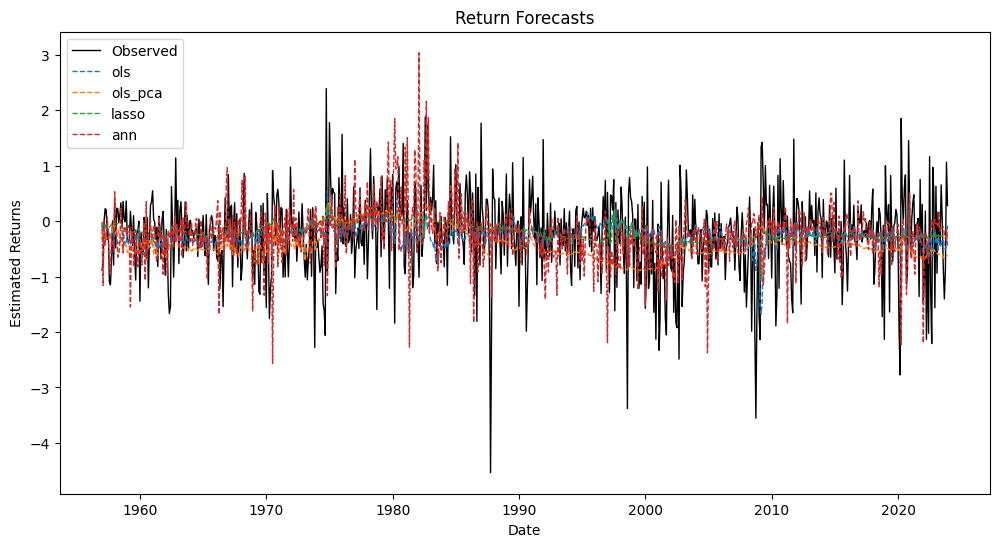

In [37]:
# Evaluate models
evaluate_models(forecast_results, actual_values)

# Plot forecasts
plot_forecasts(forecast_results, actual_values, test_indices)